In [1]:
# Magic command for automatic reload of python modules without needing to restart the notebook
%load_ext autoreload
%autoreload 2

In [5]:
import sys
import os
#adding path to the parent folder
sys.path.append(os.getcwd() + '/..')

import numpy as np
import scipy as sc
import tensorflow as tf
import tensorflow_probability as tfp
tfd=tfp.distributions
tfb=tfp.bijectors
from scipy import io
import time
import matplotlib.pyplot as plt
from sklearn import mixture
import joblib as jbl
import sklearn
import pandas as pd
import seaborn as sns
# importing mixture models and general utilities
from  mixture_models import GMCM, GMC
import utils as utl

In [6]:
# Generating data from randomly initiated GMC distribution
np.random.seed(10)
n_dims,n_comps=3,2
num_params=int(n_comps*(1+n_dims+n_dims*(n_dims+1)/2))
param_vec=np.random.randn(num_params).astype('float32')
gmm_params=utl.vec2gmm_params(n_dims,n_comps,param_vec)
alphas=tf.math.softmax(gmm_params[0])
mus=gmm_params[1]
covs=gmm_params[2]

alphas,mus,covs,_=utl.standardize_gmm_params(alphas,mus,covs)

gmm_obj = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=alphas),
    components_distribution=tfd.MultivariateNormalFullCovariance(loc=mus,
                                                                 covariance_matrix=covs))  # And same here.
# generate 100 samples
tf.random.set_seed(1)
samps=gmm_obj.sample(1000)

marg1=tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=alphas),
    components_distribution=tfd.Normal(loc=mus[:,0],
                                       scale=covs[:,0,0]**0.5))  # And same here.

marg2=tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=alphas),
    components_distribution=tfd.Normal(loc=mus[:,1],
                                       scale=covs[:,1,1]**0.5))  # And same here.

marg3=tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=alphas),
    components_distribution=tfd.Normal(loc=mus[:,2],
                                       scale=covs[:,2,2]**0.5))  # And same here.

# getting the CDF values from the true marginal distributions
u1=marg1.cdf(samps[:,0]).numpy().reshape(-1,1)
u2=marg2.cdf(samps[:,1]).numpy().reshape(-1,1)
u3=marg3.cdf(samps[:,2]).numpy().reshape(-1,1)
# concatenating all u vectors in a matrix
u_mat=np.concatenate([u1,u2,u3],axis=1)

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


In [7]:
# Training the GMC distribution WITH regularization
print('Training the GMC distribution WITH regularization')
gmc_obj=GMC(n_dims,n_comps)
gmc_obj.init_params(['random',0])
ll_reg,_,params_updates_reg=gmc_obj.fit_dist(u_mat,
                 n_comps, 
                 optimizer = tf.optimizers.Adam(learning_rate=1E-3), 
                 max_iters =2000, 
                 batch_size = 1000, 
                 print_interval=500, 
                 regularize=True, 
                 plot_results = False,
                 return_param_updates=True)

# Training the GMC distribution WITHOUT regularization
print('Training the GMC distribution WITHOUT regularization')
gmc_obj=GMC(n_dims,n_comps)
gmc_obj.init_params(['random',0])
ll_nonreg,_,params_updates_nonreg=gmc_obj.fit_dist(
    u_mat,
    n_comps, 
    optimizer = tf.optimizers.Adam(learning_rate=1E-3), 
    max_iters =2000, 
    batch_size = 1000, 
    print_interval=500, 
    regularize=False, 
    plot_results = False,
    return_param_updates=True)


Training the GMC distribution WITH regularization
@ Iter:0,                         Training error: -7.9,                         Validation error: nan,                         Time Elapsed: 5.4 s
@ Iter:500,                         Training error: -8.7,                         Validation error: nan,                         Time Elapsed: 26.0 s
@ Iter:1000,                         Training error: -9.1,                         Validation error: nan,                         Time Elapsed: 44.4 s
@ Iter:1500,                         Training error: -9.1,                         Validation error: nan,                         Time Elapsed: 62.5 s
Training the GMC distribution WITHOUT regularization
@ Iter:0,                         Training error: 0.4,                         Validation error: nan,                         Time Elapsed: 4.3 s
@ Iter:500,                         Training error: -0.3,                         Validation error: nan,                         Time Elapsed: 24.6 s
@ 

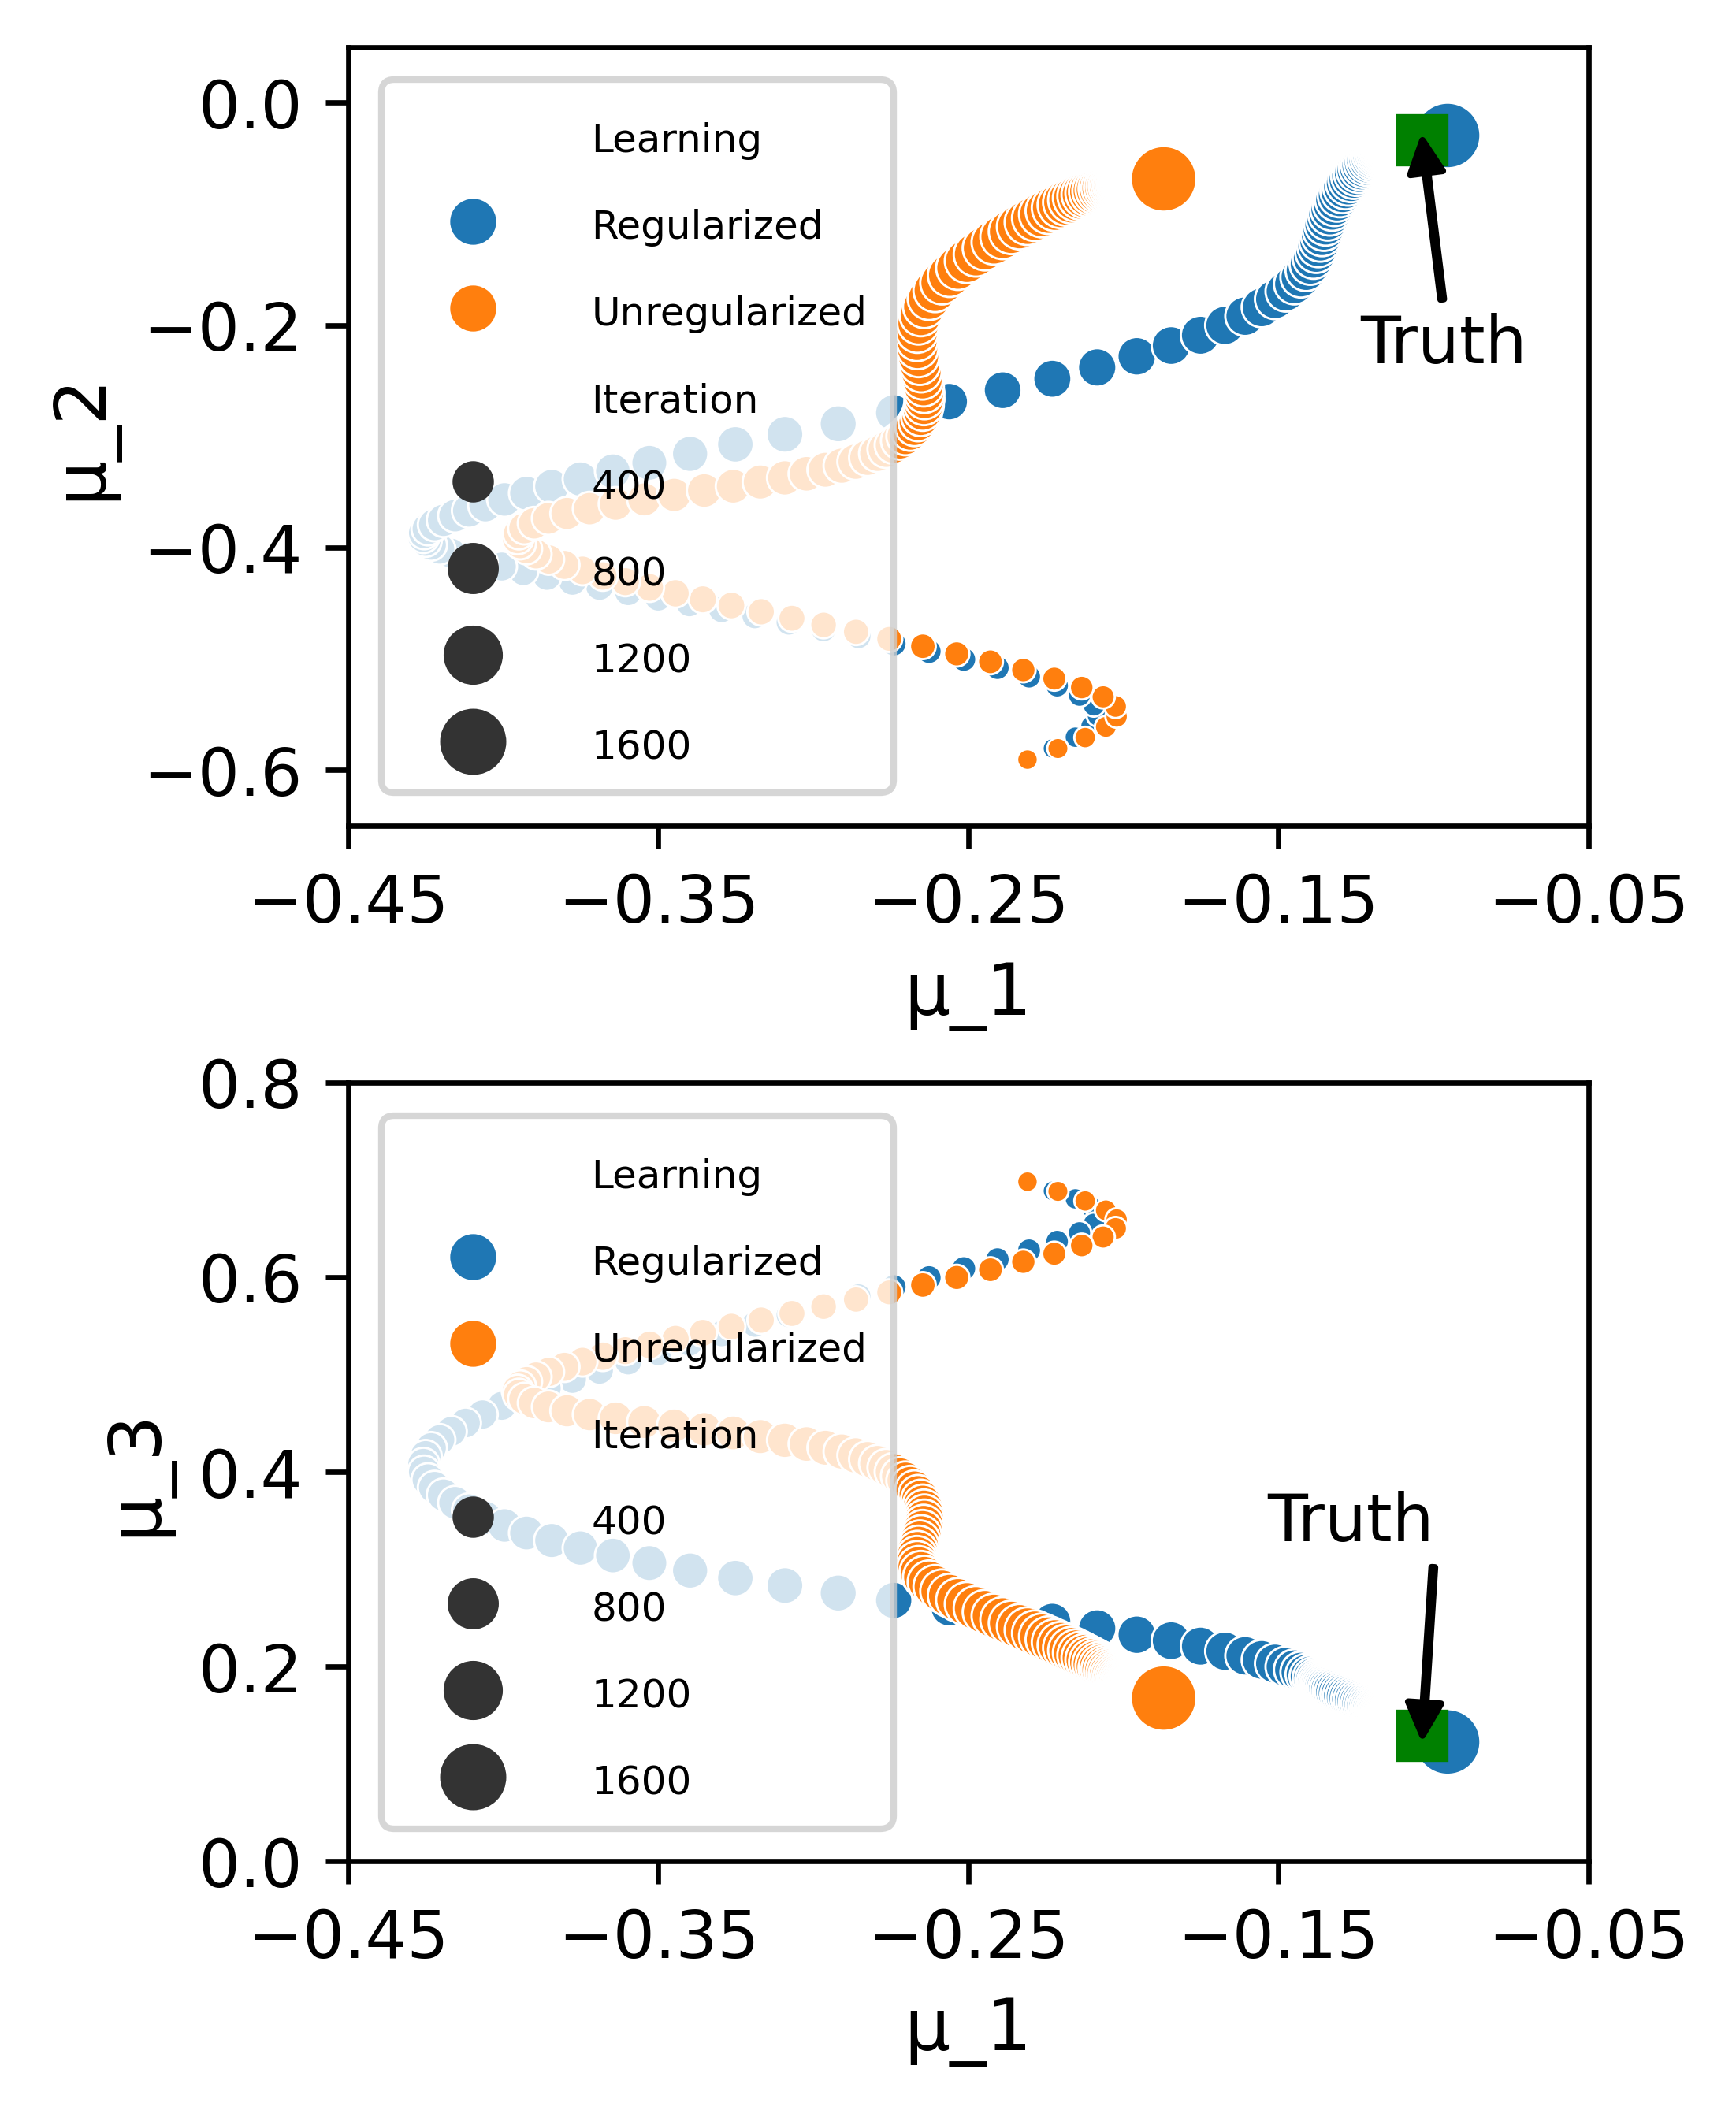

In [8]:
# Plotting the evalution of the parameters for the two cases (Regularized and Unregularized)
id1,id2,id3=2,3,4
df_reg=pd.DataFrame({'mu_1':params_updates_reg[:,id1],
                     'mu_2':params_updates_reg[:,id2],
                     'mu_3':params_updates_reg[:,id3],
                     'Iteration':np.arange(1,2001)})
df_reg['Learning']='Regularized'

df_nonreg=pd.DataFrame({'mu_1':params_updates_nonreg[:,id1],
                        'mu_2':params_updates_nonreg[:,id2],
                        'mu_3':params_updates_nonreg[:,id3],
                        'Iteration':np.arange(1,2001)})
df_nonreg['Learning']='Unregularized'

df_reg=df_reg.iloc[np.arange(0,2000,10).tolist()]
df_nonreg=df_nonreg.iloc[np.arange(0,2000,10).tolist()]

df=pd.concat((df_reg,df_nonreg),axis=0)

fig,ax=plt.subplots(2,1,figsize=(3.5,4.3),dpi=600)
sns.scatterplot(data=df, 
                x="mu_1", 
                y="mu_2",
                hue="Learning",
                size="Iteration",
                sizes=(10, 100),
                ax=ax[0])
ax[0].plot(mus[0,0],mus[0,1],'gs',markersize=7)
ax[0].annotate('Truth', xy=(mus[0,0],mus[0,1]), xytext=(mus[0,0]-0.02,mus[0,1]-0.2),
            arrowprops=dict(facecolor='black',width=0.5,headwidth=5,headlength=5))
ax[0].set_xlim([-0.45,-0.05]);
ax[0].set_ylim([-0.65,0.05]);

ax[0].legend(loc='upper left')
plt.setp(ax[0].get_legend().get_texts(), fontsize='6') 
ax[0].set_xticks([-0.45, -0.35,-0.25,-0.15,-0.05]) #unicode symbol for mu
ax[0].set_xlabel('\u03BC_1',fontsize=11) #unicode symbol for mu
ax[0].set_ylabel('\u03BC_2',fontsize=11) #unicode symbol for mu

sns.scatterplot(data=df, 
                x="mu_1", 
                y="mu_3",
                hue="Learning",
                size="Iteration",
                sizes=(10, 100),
                ax=ax[1])
ax[1].plot(mus[0,0],mus[0,2],'gs',markersize=7)
ax[1].annotate('Truth', xy=(mus[0,0],mus[0,2]), xytext=(mus[0,0]-0.05,mus[0,2]+.2),
            arrowprops=dict(facecolor='black',width=0.5,headwidth=5,headlength=5))
ax[1].set_xlim([-0.45,-0.05]);
ax[1].set_ylim([0  ,0.8]);

ax[1].set_xticks([-0.45, -0.35,-0.25,-0.15,-0.05]) 
ax[1].legend(loc='upper left')
plt.setp(ax[1].get_legend().get_texts(), fontsize='6') ;
ax[1].set_xlabel('\u03BC_1',fontsize=11) #unicode symbol for mu
ax[1].set_ylabel('\u03BC_3',fontsize=11) #unicode symbol for mu

# plt.subplots_adjust(wspace=0.1,  
#                     hspace=0.3)
plt.tight_layout(pad=0.1, 
                 h_pad=0.4, 
                 w_pad=None, 
                 rect=None)

# # saving figure
# plt.savefig('Identifiability_Experiment.png', bbox_inches='tight')
